# Preprocessing
---

In [1]:
import pandas as pd
import numpy as np

In [2]:
# func 모음

# 1. 종목코드를 6자리로 통일. ex) 990 -> 000990
def padding(x):
    return x.rjust(6, "0")

# 2. 중복인 거래소코드(column) 찾기
def find_overlap(df, column):
    NCAV1_name = df[column].unique().tolist()
    rm_list = list()

    for i in NCAV1_name:
        if (len(df[df[column]==i]) > 1):
            rm_list.append(i)
    return rm_list

# 3. 종목 표준코드 12자가 아닌게 있나?
def find_over12(df, col):
    rm = list()
    for i in range(len(df[col])):
        if len(df[col][i]) != 12:
            rm.append(i)
    return rm
## find_over12(foreign_kospi_18, "종목코드")


# 4. 표준코드를 단축코드로! 12자 중 중간 6자 반환
def extract_code(x):
    return x[3:9]

# 5. True, False 반전
def reverse_TF(x):
    if x == False:
        return True
    else:
        return False

# 6. str to int 변환
def str_to_int(x):
    return int(x)

# 7. 1000단위 제거(,)
def func_replace(x):
    return x.replace(",", "")

# 8. 제외종목 리스트 필터링
def rm_list(x):
    if (x in remove):
        return False
    else:
        return True

# 1. 펀더멘탈지표
- NCAV : (유동자산 - 총부채) / 시가총액
    - 벤자민 그레이엄의 핵심 지표
- PEGR : **PER(전일_21년도3월31일)** / **EPS 증가율(3년평균)**
    - 피터 린치의 핵심 지표
- PSR : **현재주가(21.03.31)** / **1주당 매출액(20년)**
    - 켄 피셔의 핵심 지표
- **유동비율(20년도)**
    - 유동자산의 유동부채에 대한 비율
- **부채비율(20년도)**

## 1-1. NCAV
> (유동자산 - 총부채) / 시가총액

### 1-1-1. 유동자산_총부채 전처리

In [3]:
NCAV1 = pd.read_csv("./datasets/raw/NCAV(유동자산_총부채).csv", encoding="CP949")
NCAV1

,회사명,거래소코드,회계년도,유동자산(요약)(백만원),부채총계(요약)(백만원)
0,(주)BNK금융지주,138930,2020/12,NaN,NaN
1,(주)CMG제약,58820,2020/12,145981.0,14225.0
2,(주)DB하이텍,990,2020/12,455643.0,384020.0
3,(주)ES큐브,50120,2020/12,7524.0,9046.0
4,(주)HJ중공업,97230,2020/12,1067320.0,1868707.0
...,...,...,...,...,...
2303,휴마시스(주),205470,2020/12,42484.0,19508.0
2304,휴젤(주),145020,2020/12,552590.0,191023.0
2305,흥구석유(주),24060,2020/12,27688.0,4121.0
2306,흥국화재해상보험(주),540,2020/12,NaN,NaN


In [4]:
# 중복인 거래소코드 찾기
find_overlap(NCAV1, "거래소코드")

[108320]

In [5]:
NCAV1[NCAV1["거래소코드"]==108320]

,회사명,거래소코드,회계년도,유동자산(요약)(백만원),부채총계(요약)(백만원)
744,(주)엘엑스세미콘,108320,2020/12,627617.0,218870.0
745,(주)엘엑스세미콘,108320,2020/12,627617.0,218870.0


In [6]:
NCAV1.drop(index=744, axis=0, inplace=True) # 중복회사 데이터 단일화 완료
NCAV1.columns = ['회사명', '종목코드', '회계년도', '유동자산(백만원)', '부채총계(백만원)']
NCAV1["종목코드"] = NCAV1["종목코드"].astype("str")
NCAV1["종목코드"] = NCAV1["종목코드"].map(padding)
NCAV1

,회사명,종목코드,회계년도,유동자산(백만원),부채총계(백만원)
0,(주)BNK금융지주,138930,2020/12,NaN,NaN
1,(주)CMG제약,058820,2020/12,145981.0,14225.0
2,(주)DB하이텍,000990,2020/12,455643.0,384020.0
3,(주)ES큐브,050120,2020/12,7524.0,9046.0
4,(주)HJ중공업,097230,2020/12,1067320.0,1868707.0
...,...,...,...,...,...
2303,휴마시스(주),205470,2020/12,42484.0,19508.0
2304,휴젤(주),145020,2020/12,552590.0,191023.0
2305,흥구석유(주),024060,2020/12,27688.0,4121.0
2306,흥국화재해상보험(주),000540,2020/12,NaN,NaN


### 1-1-2. 시가총액 전처리

In [7]:
NCAV2_kospi = pd.read_csv("./datasets/raw/KOSPI_시가총액(20210331).csv", encoding="CP949")
NCAV2_kosdaq = pd.read_csv("./datasets/raw/KOSDAQ_시가총액(20210331).csv", encoding="CP949")
NCAV2 = pd.concat([NCAV2_kospi,NCAV2_kosdaq], axis=0).reset_index()
NCAV2 = NCAV2[["종목코드", "시가총액"]]
NCAV2["종목코드"] = NCAV2["종목코드"].map(padding)
NCAV2["시가총액"]= NCAV2["시가총액"]/1000000
NCAV2

,종목코드,시가총액
0,095570,2.109340e+05
1,006840,3.537100e+05
2,027410,6.709750e+05
3,282330,2.730860e+06
4,138930,2.213100e+06
...,...,...
2414,024060,1.087500e+05
2415,010240,1.168190e+05
2416,189980,2.080580e+05
2417,037440,6.620137e+04


### 1-1-3. NCAV 계산

In [8]:
df_NCAV = pd.merge(NCAV1, NCAV2, on=['종목코드'], how = 'inner') # 회사수가 적은 쪽을 기준으로 합친다.(2307 vs 2419)
df_NCAV

,회사명,종목코드,회계년도,유동자산(백만원),부채총계(백만원),시가총액
0,(주)BNK금융지주,138930,2020/12,NaN,NaN,2.213100e+06
1,(주)CMG제약,058820,2020/12,145981.0,14225.0,6.090420e+05
2,(주)DB하이텍,000990,2020/12,455643.0,384020.0,2.499640e+06
3,(주)ES큐브,050120,2020/12,7524.0,9046.0,6.944812e+04
4,(주)HJ중공업,097230,2020/12,1067320.0,1868707.0,6.212260e+05
...,...,...,...,...,...,...
2179,휴마시스(주),205470,2020/12,42484.0,19508.0,2.313530e+05
2180,휴젤(주),145020,2020/12,552590.0,191023.0,2.228650e+06
2181,흥구석유(주),024060,2020/12,27688.0,4121.0,1.087500e+05
2182,흥국화재해상보험(주),000540,2020/12,NaN,NaN,2.637160e+05


In [9]:
# (유동자산 - 총부채) / 시가총액
df_NCAV["NCAV"] = (df_NCAV["유동자산(백만원)"] - df_NCAV["부채총계(백만원)"]) / df_NCAV["시가총액"] # 컬럼생성
df_NCAV.drop(['유동자산(백만원)', '부채총계(백만원)', '시가총액'], axis=1, inplace=True) # 기존 컬럼 제거
df_NCAV.dropna(axis=0, inplace=True) # 결측치 제거
df_NCAV # 끝!

,회사명,종목코드,회계년도,NCAV
1,(주)CMG제약,058820,2020/12,0.216333
2,(주)DB하이텍,000990,2020/12,0.028653
3,(주)ES큐브,050120,2020/12,-0.021916
4,(주)HJ중공업,097230,2020/12,-1.290009
7,(주)MH에탄올,023150,2020/12,-0.301897
...,...,...,...,...
2178,휴림로봇(주),090710,2020/12,-0.133651
2179,휴마시스(주),205470,2020/12,0.099311
2180,휴젤(주),145020,2020/12,0.162236
2181,흥구석유(주),024060,2020/12,0.216708


## 1-2. PEGR
> PER(전일_21년도3월31일) / EPS 증가율(3년평균)

### 1-2-1. PER 전처리

In [10]:
PEGR1 = pd.read_csv("./datasets/raw/KOSPI_PER_PBR_20210331.csv", index_col=0)
PEGR1["종목코드"] = PEGR1["종목코드"].map(padding)
PEGR1 = PEGR1[["종목코드", "PER"]]

PEGR2 = pd.read_csv("./datasets/raw/KOSDAQ_PER_PBR_20210331.csv", index_col=0)
PEGR2["종목코드"] = PEGR2["종목코드"].map(padding)
PEGR2 = PEGR2[["종목코드", "PER"]]

PEGR_PER = pd.concat([PEGR1,PEGR2], axis=0)
PEGR_PER

,종목코드,PER
0,095570,4.59
1,006840,12.32
2,027410,24.95
3,282330,18.03
4,138930,4.12
...,...,...
1469,024060,12.72
1470,010240,16.69
1471,189980,35.89
1472,037440,16.51


### 1-2-2. EPS 전처리

<img width="454" alt="image" src="https://user-images.githubusercontent.com/88031549/201609333-de085c2c-b393-4714-a978-13a4fb3116a5.png">

In [11]:
EPS_kospi_18 = pd.read_csv("./datasets/raw/코스피_EPS_2018.csv", encoding="CP949", index_col=0)
EPS_kospi_18 = EPS_kospi_18[["醫낅ぉ肄붾뱶", "EPS"]]
EPS_kospi_18.columns = ["종목코드", "EPS_2018"]

EPS_kospi_21 = pd.read_csv("./datasets/raw/코스피_EPS_2021.csv", encoding="CP949", index_col=0)
EPS_kospi_21 = EPS_kospi_21[["醫낅ぉ肄붾뱶", "EPS"]]
EPS_kospi_21.columns = ["종목코드", "EPS_2021"]

EPS_kospi = pd.merge(EPS_kospi_18, EPS_kospi_21, on=['종목코드'], how = 'inner')
EPS_kospi["EPS증가율(3년)"] = ((EPS_kospi["EPS_2021"]/EPS_kospi["EPS_2018"])**(1/3) - 1)*100
# EPS_kospi.isna().sum() # 192개 제거
EPS_kospi.dropna(axis=0, inplace=True)
EPS_kospi = EPS_kospi[["종목코드", "EPS증가율(3년)"]]
EPS_kospi = EPS_kospi[np.isinf(abs(EPS_kospi["EPS증가율(3년)"])).map(reverse_TF)] # inf 제거
EPS_kospi

,종목코드,EPS증가율(3년)
0,095570,50.512649
1,068400,26.913469
2,006840,-27.052228
3,027410,-58.085336
5,138930,2.665923
...,...,...
843,081660,-46.377207
844,005870,-24.211060
845,079980,-100.000000
847,069260,17.464183


In [12]:
EPS_kosdaq_18 = pd.read_csv("./datasets/raw/코스닥_EPS_2018.csv", encoding="CP949", index_col=0)
EPS_kosdaq_18 = EPS_kosdaq_18[["醫낅ぉ肄붾뱶", "EPS"]]
EPS_kosdaq_18.columns = ["종목코드", "EPS_2018"]

EPS_kosdaq_21 = pd.read_csv("./datasets/raw/코스닥_EPS_2021.csv", encoding="CP949", index_col=0)
EPS_kosdaq_21 = EPS_kosdaq_21[["醫낅ぉ肄붾뱶", "EPS"]]
EPS_kosdaq_21.columns = ["종목코드", "EPS_2021"]

EPS_kosdaq = pd.merge(EPS_kosdaq_18, EPS_kosdaq_21, on=['종목코드'], how = 'inner')
EPS_kosdaq["EPS증가율(3년)"] = ((EPS_kosdaq["EPS_2021"]/EPS_kosdaq["EPS_2018"])**(1/3) - 1)*100
# EPS_kosdaq.isna().sum() # 254개 제거
EPS_kosdaq.dropna(axis=0, inplace=True)
EPS_kosdaq = EPS_kosdaq[["종목코드", "EPS증가율(3년)"]]
EPS_kosdaq = EPS_kosdaq[np.isinf(abs(EPS_kosdaq["EPS증가율(3년)"])).map(reverse_TF)] # inf 제거
EPS_kosdaq

,종목코드,EPS증가율(3년)
1,054620,-100.000000
3,211270,-52.404085
4,035760,10.967868
6,058820,9.579371
7,023460,67.638764
...,...,...
1189,024060,56.049075
1190,010240,-1.090787
1191,189980,-31.751290
1192,037440,19.920107


In [13]:
df_EPS = pd.concat([EPS_kospi, EPS_kosdaq], axis=0)
df_EPS

,종목코드,EPS증가율(3년)
0,095570,50.512649
1,068400,26.913469
2,006840,-27.052228
3,027410,-58.085336
5,138930,2.665923
...,...,...
1189,024060,56.049075
1190,010240,-1.090787
1191,189980,-31.751290
1192,037440,19.920107


### 1-2-3. PEGR 계산

In [14]:
df_PEGR = pd.merge(PEGR_PER, df_EPS, on=['종목코드'], how = 'inner')
df_PEGR["PEGR"] = df_PEGR["PER"]/df_PEGR["EPS증가율(3년)"]
df_PEGR = df_PEGR[["종목코드", "PEGR"]]
df_PEGR = df_PEGR[np.isinf(abs(df_PEGR["PEGR"])).map(reverse_TF)]
df_PEGR

,종목코드,PEGR
0,095570,0.090868
1,006840,-0.455415
2,027410,-0.429540
3,138930,1.545431
4,001460,1.679799
...,...,...
1399,024060,0.226944
1400,010240,-15.300874
1401,189980,-1.130348
1402,037440,0.828811


## 1-3. PSR
> 현재주가(21.03.31) / 1주당 매출액(20년)

### 1-3-1. 현재주가 전처리

In [15]:
PSR1 = pd.read_csv("./datasets/raw/현재주가(210331).csv", index_col=0)
PSR1 = PSR1[['종목코드', '종가']]
PSR1["종목코드"] = PSR1["종목코드"].astype("str")
PSR1["종목코드"] = PSR1["종목코드"].map(padding)
PSR1

,종목코드,종가
0,058820,4385
1,000990,56300
2,050120,5120
3,097230,7460
4,023150,8710
...,...,...
2021,090710,1085
2022,205470,6760
2023,145020,178500
2024,024060,7250


### 1-3-2. 1주당 매출액 전처리(여기서 금융, 보험, 지주 제외)

In [16]:
PSR2 = pd.read_csv("./datasets/raw/1주당매출액_매출액(2020).csv", encoding="CP949")
PSR2 = PSR2[["회사명", "거래소코드", "매출액(영업수익)(*)(천원)"]]
PSR2.columns = ["회사명", "종목코드", "매출액(원)"]
PSR2["매출액(원)"] = PSR2["매출액(원)"]*1000
PSR2["종목코드"] = PSR2["종목코드"].astype("str")
PSR2["종목코드"] = PSR2["종목코드"].map(padding)

PSR3 = pd.read_csv("./datasets/raw/1주당매출액_상장주식수(21.03.31).csv", encoding="UTF-8")
PSR3 = PSR3[["종목코드", "상장주식수"]]
PSR3["상장주식수"] = PSR3["상장주식수"].map(func_replace)
PSR3["상장주식수"] = PSR3["상장주식수"].map(str_to_int)

PSR4 = pd.merge(PSR2, PSR3, on=['종목코드'], how = 'inner')
PSR4["1주당매출액"] = PSR4["매출액(원)"]/PSR4["상장주식수"]
PSR4 = PSR4[["회사명", "종목코드", "1주당매출액"]]
PSR4

,회사명,종목코드,1주당매출액
0,(주)CMG제약,058820,464.100004
1,(주)DB하이텍,000990,21079.944389
2,(주)ES큐브,050120,364.589291
3,(주)HJ중공업,097230,20350.028600
4,(주)MH에탄올,023150,6949.539108
...,...,...,...
2021,휴림로봇(주),090710,239.855549
2022,휴마시스(주),205470,1539.101901
2023,휴젤(주),145020,42537.336869
2024,흥구석유(주),024060,7656.249000


In [17]:
find_overlap(PSR4, "종목코드")

['108320']

In [18]:
PSR4[PSR4["종목코드"]=="108320"]

,회사명,종목코드,1주당매출액
653,(주)엘엑스세미콘,108320,71438.444077
654,(주)엘엑스세미콘,108320,71438.444077


In [19]:
PSR4.drop(index=653, inplace=True)
PSR4

,회사명,종목코드,1주당매출액
0,(주)CMG제약,058820,464.100004
1,(주)DB하이텍,000990,21079.944389
2,(주)ES큐브,050120,364.589291
3,(주)HJ중공업,097230,20350.028600
4,(주)MH에탄올,023150,6949.539108
...,...,...,...
2021,휴림로봇(주),090710,239.855549
2022,휴마시스(주),205470,1539.101901
2023,휴젤(주),145020,42537.336869
2024,흥구석유(주),024060,7656.249000


### 1-3-3. PSR 계산

In [20]:
df_PSR = pd.merge(PSR1, PSR4, on=['종목코드'], how = 'inner') # 회사수가 적은 쪽을 기준으로 합친다.(1748 vs 2331)
df_PSR["PSR"] = df_PSR["종가"] / df_PSR["1주당매출액"]
df_PSR = df_PSR[["회사명", "종목코드", "PSR"]]
df_PSR.dropna(inplace=True) # 25개 drop
df_PSR

,회사명,종목코드,PSR
0,(주)CMG제약,058820,9.448395
1,(주)DB하이텍,000990,2.670785
2,(주)ES큐브,050120,14.043199
3,(주)HJ중공업,097230,0.366584
4,(주)MH에탄올,023150,1.253321
...,...,...,...
2021,휴림로봇(주),090710,4.523556
2022,휴마시스(주),205470,4.392172
2023,휴젤(주),145020,4.196313
2024,흥구석유(주),024060,0.946939


In [21]:
# 회사 확인
# df_PSR[df_PSR["종목코드"]=="097950"]

## 1-4. 유동비율 & 부채비율

In [22]:
유부비율 = pd.read_csv("./datasets/raw/부채비율_유동비율(2020).csv", encoding="CP949")
유부비율.columns = ['회사명', '종목코드', '회계년도', '부채비율', '유동비율']
유부비율 = 유부비율[['회사명', '종목코드', '부채비율', '유동비율']]
유부비율["종목코드"] = 유부비율["종목코드"].astype("str")
유부비율["종목코드"] = 유부비율["종목코드"].map(padding)
유부비율

,회사명,종목코드,부채비율,유동비율
0,(주)BNK금융지주,138930,NaN,NaN
1,(주)CMG제약,058820,7.85,1069.54
2,(주)DB하이텍,000990,48.29,174.09
3,(주)ES큐브,050120,12.40,90.15
4,(주)HJ중공업,097230,583.21,103.45
...,...,...,...,...
2327,휴마시스(주),205470,39.94,439.90
2328,휴젤(주),145020,28.38,879.33
2329,흥구석유(주),024060,5.18,1108.08
2330,흥국화재해상보험(주),000540,NaN,NaN


In [23]:
find_overlap(유부비율, "종목코드")

['108320']

In [24]:
유부비율[유부비율["종목코드"]=="108320"]

,회사명,종목코드,부채비율,유동비율
752,(주)엘엑스세미콘,108320,41.22,299.33
753,(주)엘엑스세미콘,108320,41.22,299.33


In [25]:
유부비율.drop(index=752, axis=0, inplace=True)
유부비율.dropna(axis=0, inplace=True)
유부비율

,회사명,종목코드,부채비율,유동비율
1,(주)CMG제약,058820,7.85,1069.54
2,(주)DB하이텍,000990,48.29,174.09
3,(주)ES큐브,050120,12.40,90.15
4,(주)HJ중공업,097230,583.21,103.45
7,(주)MH에탄올,023150,69.27,117.69
...,...,...,...,...
2326,휴림로봇(주),090710,71.30,86.30
2327,휴마시스(주),205470,39.94,439.90
2328,휴젤(주),145020,28.38,879.33
2329,흥구석유(주),024060,5.18,1108.08


## 1-5. 펀더멜탈 지표 merge

- 1.1 : df_NCAV / 2066개
- 1.2 : df_PEGR
- 1.3 : df_PSR / 1748개
- 1.4 & 1.5 : 유부비율 / 2181개

In [26]:
df_fundamental = pd.merge(df_NCAV, df_PEGR,on=['종목코드'],how='inner')
df_fundamental = pd.merge(df_fundamental, df_PSR,on=['종목코드'],how='inner')
df_fundamental = pd.merge(df_fundamental, 유부비율,on=['종목코드'],how='inner')
df_fundamental = df_fundamental[['종목코드', '회사명_y', 'NCAV', 'PEGR', 'PSR', '유동비율', '부채비율']]
df_fundamental.columns = ['종목코드', '회사명', 'NCAV', 'PEGR', 'PSR', '유동비율', '부채비율']
df_fundamental

,종목코드,회사명,NCAV,PEGR,PSR,유동비율,부채비율
0,058820,(주)CMG제약,0.216333,18.310180,9.448395,1069.54,7.85
1,000990,(주)DB하이텍,0.028653,4.113681,2.670785,174.09,48.29
2,050120,(주)ES큐브,-0.021916,-0.000000,14.043199,90.15,12.40
3,023150,(주)MH에탄올,-0.301897,-0.000000,1.253321,117.69,69.27
4,002360,(주)SH에너지화학,0.361237,-0.000000,1.143522,917.82,29.79
...,...,...,...,...,...,...,...
1298,094280,효성아이티엑스(주),-0.235806,1.557279,0.485197,63.82,227.69
1299,090710,휴림로봇(주),-0.133651,-0.000000,4.523556,86.30,71.30
1300,205470,휴마시스(주),0.099311,-0.000000,4.392172,439.90,39.94
1301,145020,휴젤(주),0.162236,-1.405916,4.196313,879.33,28.38


In [27]:
# 종목확인
# df_fundamental[df_fundamental["종목코드"]=="028080"]

## 1-6. 관리, 거래정지, 우선주 종목 제외

In [28]:
rm_list1 = pd.read_csv("./datasets/관리종목 현황f.csv", encoding="CP949")
rm_list2 = pd.read_csv("./datasets/매매거래정지종목 현황f.csv", encoding="CP949")

rm_list = pd.concat([rm_list1,rm_list2], axis=0)
rm_list["종목코드"] = rm_list["종목코드"].astype("str")
rm_list["종목코드"] = rm_list["종목코드"].map(padding)
rm_list = rm_list["종목코드"].tolist()
# rm_list
remove = ['141020', '103230', '058420', '263540', '160600', '114120', '050540', '058220', '009730', '121890', '180400', '223310', '138360', '038340', '003620', '069110', '058530', '208860', '257370', '056000', '102940', '175140', '033340', '299910', '099520', '006580', '033790', '141020', '058220', '121890', '160600', '263540', '109070', '223310', '058530', '257370', '003620', '056000', '058420', '101680', '006580', '103230', '065560', '178780', '103660', '033340', '078590', '069110', '099520', '038340', '012600', '015540']

In [29]:
def rm_list(x):
    if (x in remove):
        return False
    else:
        return True

In [30]:
# rm_list
df_fundamental = df_fundamental[df_fundamental["종목코드"].map(rm_list)] # 1303 -> 1293개로 10개 줄어들음
df_fundamental

,종목코드,회사명,NCAV,PEGR,PSR,유동비율,부채비율
0,058820,(주)CMG제약,0.216333,18.310180,9.448395,1069.54,7.85
1,000990,(주)DB하이텍,0.028653,4.113681,2.670785,174.09,48.29
2,050120,(주)ES큐브,-0.021916,-0.000000,14.043199,90.15,12.40
3,023150,(주)MH에탄올,-0.301897,-0.000000,1.253321,117.69,69.27
4,002360,(주)SH에너지화학,0.361237,-0.000000,1.143522,917.82,29.79
...,...,...,...,...,...,...,...
1298,094280,효성아이티엑스(주),-0.235806,1.557279,0.485197,63.82,227.69
1299,090710,휴림로봇(주),-0.133651,-0.000000,4.523556,86.30,71.30
1300,205470,휴마시스(주),0.099311,-0.000000,4.392172,439.90,39.94
1301,145020,휴젤(주),0.162236,-1.405916,4.196313,879.33,28.38


제거종목(10개)  
<img width="717" alt="image" src="https://user-images.githubusercontent.com/88031549/202114016-7932a36a-a5d9-4332-9fc4-2980332e4164.png">


우선주 확인

In [31]:
def rm_list2(x):
    if "우선" in x:
        return True
    else:
        return False

In [32]:
df_fundamental[df_fundamental["회사명"].map(rm_list2)] # 우선주 없음 확인

,종목코드,회사명,NCAV,PEGR,PSR,유동비율,부채비율


## 1-7. 최종_펀더멘탈 data 가져오기

In [34]:
# df_fundamental.to_csv("./datasets/1_fundamental.csv")
# df_fundamental.to_excel("./datasets/1_fundamental.xlsx")
df_fundamental = pd.read_csv("./datasets/1_fundamental.csv", index_col=0)
df_fundamental["종목코드"] = df_fundamental["종목코드"].astype("str")
df_fundamental["종목코드"] = df_fundamental["종목코드"].map(padding)
df_fundamental

,종목코드,회사명,NCAV,PEGR,PSR,유동비율,부채비율
0,058820,(주)CMG제약,0.216333,18.310180,9.448395,1069.54,7.85
1,000990,(주)DB하이텍,0.028653,4.113681,2.670785,174.09,48.29
2,050120,(주)ES큐브,-0.021916,-0.000000,14.043199,90.15,12.40
3,023150,(주)MH에탄올,-0.301897,-0.000000,1.253321,117.69,69.27
4,002360,(주)SH에너지화학,0.361237,-0.000000,1.143522,917.82,29.79
...,...,...,...,...,...,...,...
1298,094280,효성아이티엑스(주),-0.235806,1.557279,0.485197,63.82,227.69
1299,090710,휴림로봇(주),-0.133651,-0.000000,4.523556,86.30,71.30
1300,205470,휴마시스(주),0.099311,-0.000000,4.392172,439.90,39.94
1301,145020,휴젤(주),0.162236,-1.405916,4.196313,879.33,28.38


---
# 2. 위험 성과 지표

- 수익률 평균 : 일별 변동%(1년평균)
- 샤프지수 평균 : 초과수익률 / 위험률
  - (해당종목 연간수익률 - 1년만기국채수익률(1년전당일)) / 일별 변동의 표준편차

## 2-1. 수익률 평균(일일변동평균)
> 수익률 평균 : 일별 변동성 평균(1년간)

In [35]:
danger1_kospi = pd.read_csv("./datasets/raw/일일변동평균_코스피.csv", index_col=0)
danger1_kospi.columns = ['종목코드', '일일변동평균']
danger1_kosdaq = pd.read_csv("./datasets/raw/일일변동평균_코스닥.csv", index_col=0)
danger1_kosdaq.columns = ['종목코드', '일일변동평균']

df_danger1 = pd.concat([danger1_kospi, danger1_kosdaq], axis=0)
df_danger1.dropna(inplace=True)
df_danger1

,종목코드,일일변동평균
0,000020,0.448072
1,000040,0.463396
2,000050,0.272259
3,000060,0.210136
4,000070,0.387246
...,...,...
1441,363260,-1.377531
1442,369370,-0.822824
1443,900260,0.068847
1444,950190,1.798720


## 2-2. 샤프지수
> 샤프지수 평균 : (해당종목 연간수익률 - 1년만기국채수익률(1년전당일)) / 일별 변동의 표준편차

In [36]:
danger2_kospi = pd.read_csv("./datasets/raw/샤프지수_코스피.csv", index_col=0)
danger2_kospi.columns = ['종목코드', '일별변동_표준편차', '1년_만기_국채수익률', '연간수익률', '샤프지수']
danger2_kosdaq = pd.read_csv("./datasets/raw/샤프지수_코스닥.csv", index_col=0)
danger2_kosdaq.columns = ['종목코드', '일별변동_표준편차', '1년_만기_국채수익률', '연간수익률', '샤프지수']

df_danger2 = pd.concat([danger2_kospi, danger2_kosdaq], axis=0)
df_danger2 = df_danger2[["종목코드", "샤프지수"]]
df_danger2.dropna(inplace=True)
df_danger2

,종목코드,샤프지수
0,000020,21.871311
1,000040,21.853372
2,000050,18.307817
3,000060,28.335299
4,000070,37.741516
...,...,...
1429,331520,10.806090
1431,333050,10.139528
1432,335890,-0.769720
1435,340440,7.150877


## 2-3. 위험성과지표 merge & inf 제거

In [37]:
df_danger = pd.merge(df_danger1, df_danger2, on=['종목코드'], how = 'inner')
df_danger

,종목코드,일일변동평균,샤프지수
0,000020,0.448072,21.871311
1,000040,0.463396,21.853372
2,000050,0.272259,18.307817
3,000060,0.210136,28.335299
4,000070,0.387246,37.741516
...,...,...,...
1608,331520,0.021582,10.806090
1609,333050,0.017838,10.139528
1610,335890,0.015328,-0.769720
1611,340440,0.013375,7.150877


In [38]:
df_danger.isna().sum()

종목코드      0
일일변동평균    0
샤프지수      0
dtype: int64

In [39]:
np.isinf(abs(df_danger["샤프지수"])).sum() # inf21개 존재

21

In [40]:
df_danger = df_danger[np.isinf(abs(df_danger["샤프지수"])).map(reverse_TF)]
df_danger

,종목코드,일일변동평균,샤프지수
0,000020,0.448072,21.871311
1,000040,0.463396,21.853372
2,000050,0.272259,18.307817
3,000060,0.210136,28.335299
4,000070,0.387246,37.741516
...,...,...,...
1608,331520,0.021582,10.806090
1609,333050,0.017838,10.139528
1610,335890,0.015328,-0.769720
1611,340440,0.013375,7.150877


## 2-4. 관리, 거래정지 종목제거

In [41]:
remove = ['141020', '103230', '058420', '263540', '160600', '114120', '050540', '058220', '009730', '121890', '180400', '223310', '138360', '038340', '003620', '069110', '058530', '208860', '257370', '056000', '102940', '175140', '033340', '299910', '099520', '006580', '033790', '141020', '058220', '121890', '160600', '263540', '109070', '223310', '058530', '257370', '003620', '056000', '058420', '101680', '006580', '103230', '065560', '178780', '103660', '033340', '078590', '069110', '099520', '038340', '012600', '015540']

# rm_list
df_danger = df_danger[df_danger["종목코드"].map(rm_list)] # 1592 -> 1578개로 14개 줄어들음
df_danger

,종목코드,일일변동평균,샤프지수
0,000020,0.448072,21.871311
1,000040,0.463396,21.853372
2,000050,0.272259,18.307817
3,000060,0.210136,28.335299
4,000070,0.387246,37.741516
...,...,...,...
1608,331520,0.021582,10.806090
1609,333050,0.017838,10.139528
1610,335890,0.015328,-0.769720
1611,340440,0.013375,7.150877


## 2-5. 위험성과지표 data 들고오기

In [43]:
# df_danger.to_csv("./datasets/2_danger.csv")
df_danger = pd.read_csv("./datasets/2_danger.csv", index_col=0)
df_danger

,종목코드,일일변동평균,샤프지수
0,000020,0.448072,21.871311
1,000040,0.463396,21.853372
2,000050,0.272259,18.307817
3,000060,0.210136,28.335299
4,000070,0.387246,37.741516
...,...,...,...
1608,331520,0.021582,10.806090
1609,333050,0.017838,10.139528
1610,335890,0.015328,-0.769720
1611,340440,0.013375,7.150877


---
# 3. 팩터지표

- 가치(Value) : PER, PBR
    - 가치주가 장기적으로 성장주보다 투자 성과가 좋음
- ~~변동성(Volaity) : 변동성(월)~~
    - 변동성이 낮은 종목이 장기적으로 성과가 우수함
- ~~배당(Dividend) : 배당수익률~~
    - 배당수익률이 높을수록 투자 수익률도 높음
- 사이즈(Size) : 시가총액

## 3-1. 팩터지표 전처리

In [ ]:
# import pandas as pd
# import numpy as np
# import getpass
# from pykrx import stock

In [ ]:
# # 코스닥 PER 21년 3월 31일
# KOSDAQ_PER_2021= pd.DataFrame(stock.get_market_fundamental_by_ticker(date='20210331', market="KOSDAQ"))
# KOSDAQ_PER_2021['종목코드'] =  KOSDAQ_PER_2021.index
# KOSDAQ_PER_2021.reset_index(inplace=True)
# KOSDAQ_PER_2021.drop(columns='티커', inplace=True)
# KOSDAQ_PER_2021 = KOSDAQ_PER_2021[['종목코드', 'PER', 'PBR', 'EPS', 'BPS', 'DIV', 'DPS']]

# KDQ_PER_BBR_2021 = KOSDAQ_PER_2021[['종목코드', 'PER', 'PBR']]

# # 코스닥 PER PBR
# KDQ_PER_BBR_2021.head(3)

,종목코드,PER,PBR
0,060310,0.0,3.21
1,054620,0.0,0.92
2,265520,42.7,3.84


In [ ]:
# # 코스피 PER 21년 3월 31일
# KOSPI_PER_2021= pd.DataFrame(stock.get_market_fundamental_by_ticker(date='20210331', market="KOSPI"))
# KOSPI_PER_2021['종목코드'] =  KOSPI_PER_2021.index
# KOSPI_PER_2021.reset_index(inplace=True)
# KOSPI_PER_2021.drop(columns='티커', inplace=True)
# KOSPI_PER_2021 = KOSPI_PER_2021[['종목코드', 'PER', 'PBR', 'EPS', 'BPS', 'DIV', 'DPS']]

# KSP_PER_PBR_2P21 = KOSPI_PER_2021[['종목코드', 'PER', 'PBR']]

# # 코스피
# KSP_PER_PBR_2P21.head(3)

,종목코드,PER,PBR
0,095570,4.59,0.66
1,006840,12.32,0.43
2,027410,24.95,0.45


In [ ]:
# # 시가총액

# # 코스닥 시가총액
# qr1 = pd.read_csv('./코스닥_시가총액.csv', encoding ='cp949')
# KDQ_money = qr1[['종목코드', '종목명', '상장주식수']]

# # 코스피 시가총액
# qr2 = pd.read_csv('./코스피_시가총액.csv', encoding ='cp949')
# KSP_money = qr2[['종목코드', '종목명', '상장주식수']]

In [ ]:
# # [코스닥] 종목 코드 기준으로 파일 합치기
# KOSDAQ_FACTOR = pd.merge(KDQ_PER_BBR_2021, KDQ_money, on= '종목코드', how='inner')
# KOSDAQ_FACTOR = KOSDAQ_FACTOR[['종목코드', '종목명', 'PER',	'PBR', '상장주식수']]
# KOSDAQ_FACTOR.head(1)

,종목코드,종목명,PER,PBR,상장주식수
0,060310,3S,0.0,3.21,45211895


In [ ]:
# # [코스피] 종목 코드 기준으로 파일 합치기
# KOSPI_FACTOR = pd.merge(KSP_PER_PBR_2P21, KSP_money, on= '종목코드', how='inner')
# KOSPI_FACTOR = KOSPI_FACTOR[['종목코드', '종목명', 'PER',	'PBR', '상장주식수']]
# KOSPI_FACTOR.head(1)

,종목코드,종목명,PER,PBR,상장주식수
0,095570,AJ네트웍스,4.59,0.66,46822295


In [ ]:
# # df저장
# KOSDAQ_FACTOR.to_csv('팩터지표_코스닥.csv')
# KOSPI_FACTOR.to_csv('팩터지표_코스피.csv')

In [44]:
factor_kospi = pd.read_csv("./datasets/raw/팩터지표_코스피.csv", index_col=0)
factor_kosdaq = pd.read_csv("./datasets/raw/팩터지표_코스닥.csv", index_col=0)
df_factor = pd.concat([factor_kospi, factor_kosdaq], axis=0)
df_factor

,종목코드,종목명,PER,PBR,시가총액
0,095570,AJ네트웍스,4.59,0.66,210934.0
1,006840,AK홀딩스,12.32,0.43,353710.0
2,027410,BGF,24.95,0.45,670975.0
3,282330,BGF리테일,18.03,4.39,2730857.0
4,138930,BNK금융지주,4.12,0.27,2213100.0
...,...,...,...,...,...
1469,024060,흥구석유,12.72,1.41,108750.0
1470,010240,흥국,16.69,1.73,116819.0
1471,189980,흥국에프엔비,35.89,3.11,208058.0
1472,037440,희림,16.51,1.24,66201.0


## 3-2. 관리&거래정지종목, inf 제거

In [45]:
df_factor.isna().sum()

종목코드    0
종목명     0
PER     0
PBR     0
시가총액    0
dtype: int64

In [46]:
np.isinf(abs(df_factor["시가총액"])).sum() # inf없음

0

In [47]:
remove = ['141020', '103230', '058420', '263540', '160600', '114120', '050540', '058220', '009730', '121890', '180400', '223310', '138360', '038340', '003620', '069110', '058530', '208860', '257370', '056000', '102940', '175140', '033340', '299910', '099520', '006580', '033790', '141020', '058220', '121890', '160600', '263540', '109070', '223310', '058530', '257370', '003620', '056000', '058420', '101680', '006580', '103230', '065560', '178780', '103660', '033340', '078590', '069110', '099520', '038340', '012600', '015540']

# rm_list
df_factor = df_factor[df_factor["종목코드"].map(rm_list)] # 2374 -> 2340개로 34개 줄어들음
df_factor

,종목코드,종목명,PER,PBR,시가총액
0,095570,AJ네트웍스,4.59,0.66,210934.0
1,006840,AK홀딩스,12.32,0.43,353710.0
2,027410,BGF,24.95,0.45,670975.0
3,282330,BGF리테일,18.03,4.39,2730857.0
4,138930,BNK금융지주,4.12,0.27,2213100.0
...,...,...,...,...,...
1469,024060,흥구석유,12.72,1.41,108750.0
1470,010240,흥국,16.69,1.73,116819.0
1471,189980,흥국에프엔비,35.89,3.11,208058.0
1472,037440,희림,16.51,1.24,66201.0


## 3-3. 팩터지표 data 가져오기

In [49]:
# df_factor.to_csv("./datasets/3_factor.csv")
df_factor = pd.read_csv("./datasets/3_factor.csv", index_col=0)
df_factor

,종목코드,종목명,PER,PBR,시가총액
0,095570,AJ네트웍스,4.59,0.66,210934.0
1,006840,AK홀딩스,12.32,0.43,353710.0
2,027410,BGF,24.95,0.45,670975.0
3,282330,BGF리테일,18.03,4.39,2730857.0
4,138930,BNK금융지주,4.12,0.27,2213100.0
...,...,...,...,...,...
1469,024060,흥구석유,12.72,1.41,108750.0
1470,010240,흥국,16.69,1.73,116819.0
1471,189980,흥국에프엔비,35.89,3.11,208058.0
1472,037440,희림,16.51,1.24,66201.0


---
# 4. 수급지표(안씀)

## 4-1. 외국인 순매수금액 추세

In [182]:
purchase_kospi = pd.read_csv("./datasets/raw/KOSPI_외국인일순매수금액.csv", index_col=0)
purchase_kosdaq = pd.read_csv("./datasets/raw/KOSDAQ_외국인일순매수금액.csv", index_col=0)
foreign_purchase = pd.concat([purchase_kospi, purchase_kosdaq], axis=0)
foreign_purchase["종목코드"] = foreign_purchase["종목코드"].map(extract_code)
foreign_purchase

,거래일자,종목코드,외국인_일순매수금액
0,20210318,000020,-379817600
1,20210318,000040,-97083655
2,20210318,000050,-7594200
3,20210318,000060,-2473691750
4,20210318,000070,677092600
...,...,...,...
13570,20210331,840150,22405850
13571,20210331,1990V1,65023732
13572,20210331,2114A1,45685162
13573,20210331,2115T1,130696425


In [253]:
import statsmodels.api as sm

종목코드 = "005930"

x = [1,2,3,4,5,6,7,8,9,10] # x축은 10일간
y = foreign_purchase[foreign_purchase["종목코드"]==종목코드]["외국인_일순매수금액"]/pow(10,6) # y축은 외국인 순매수금액
X = sm.add_constant(x) # 절편 추가
model = sm.OLS(y, X).fit() # 회귀 모형 학습
predictions = model.predict(X) # 예측치 생성
model.summary()

# int(str(model.params[1])[:4])/1000

/Users/kyle/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             외국인_일순매수금액   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.118
Method:                 Least Squares   F-statistic:                   0.04824
Date:                Mon, 14 Nov 2022   Prob (F-statistic):              0.832
Time:                        16:18:33   Log-Likelihood:                -132.49
No. Observations:                  10   AIC:                             269.0
Df Residuals:                       8   BIC:                             269.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.525e+04   1.05e+05     -0.145      0.888   -2.57e+05    2.27e+05
x1         -3714.2009   1.69e+04     -0.220      0.832   -4.27e+04    3.53e+04
==============================================================================
Omnibus:                        0.468   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.791   Jarque-Bera (JB):                0.503
Skew:                           0.361   Prob(JB):                        0.777
Kurtosis:                       2.171   Cond. No.                         13.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

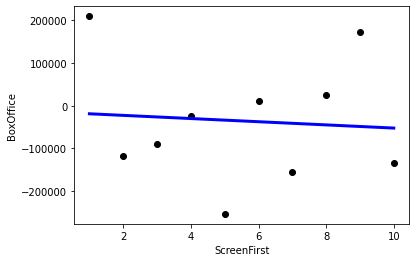

In [254]:
import matplotlib.pyplot as plt

plt.scatter(x, y, color='black')
plt.plot(x, predictions, color='blue', linewidth=3)
plt.xlabel('ScreenFirst')
plt.ylabel('BoxOffice')
plt.show()

In [255]:
# 회귀계수(기울기)
round(model.params[1],3)

-3714.201

## 4-2. 외국인 체결강도 일평균(2주간)  
> 일별 (외국인매수거래량/외국인매도거래량)*100 의 평균(2주)

### 4-2-1. KOSPI 전처리

In [143]:
# foreign_kospi_18 = pd.read_csv("./datasets/raw/foreign/KOSPI_외국인/KOSPI_20210318.csv",encoding="CP949")
# foreign_kospi_19 = pd.read_csv("./datasets/raw/foreign/KOSPI_외국인/KOSPI_20210319.csv",encoding="CP949")
# foreign_kospi_22 = pd.read_csv("./datasets/raw/foreign/KOSPI_외국인/KOSPI_20210322.csv",encoding="CP949")
# foreign_kospi_23 = pd.read_csv("./datasets/raw/foreign/KOSPI_외국인/KOSPI_20210323.csv",encoding="CP949")
# foreign_kospi_24 = pd.read_csv("./datasets/raw/foreign/KOSPI_외국인/KOSPI_20210324.csv",encoding="CP949")
# foreign_kospi_25 = pd.read_csv("./datasets/raw/foreign/KOSPI_외국인/KOSPI_20210325.csv",encoding="CP949")
# foreign_kospi_26 = pd.read_csv("./datasets/raw/foreign/KOSPI_외국인/KOSPI_20210326.csv",encoding="CP949")
# foreign_kospi_29 = pd.read_csv("./datasets/raw/foreign/KOSPI_외국인/KOSPI_20210329.csv",encoding="CP949")
# foreign_kospi_30 = pd.read_csv("./datasets/raw/foreign/KOSPI_외국인/KOSPI_20210330.csv",encoding="CP949")
# foreign_kospi_31 = pd.read_csv("./datasets/raw/foreign/KOSPI_외국인/KOSPI_20210331.csv",encoding="CP949")

# foreign_kospi = pd.concat([foreign_kospi_18, foreign_kospi_19, foreign_kospi_22,
#                         foreign_kospi_23, foreign_kospi_24, foreign_kospi_25,
#                         foreign_kospi_26, foreign_kospi_29, foreign_kospi_30,
#                         foreign_kospi_31], axis=0)
# foreign_kospi = foreign_kospi[foreign_kospi["투자자구분코드"]==9000]

In [144]:
# foreign_kospi = foreign_kospi[['거래일자','종목코드', '종목명', '매도거래량', '매수거래량']]
# # find_over12(foreign_kospi, "종목코드") # 종목코드 12가 아닌게 있는지 check!
# foreign_kospi["종목코드"] = foreign_kospi["종목코드"].map(extract_code)

# # 체결강도계산
# foreign_kospi = foreign_kospi.groupby('종목코드')['매도거래량','매수거래량'].sum()
# foreign_kospi['외국인체결강도'] = np.round(foreign_kospi['매수거래량'] / foreign_kospi['매도거래량']*100, 4)
# foreign_kospi.reset_index(inplace=True,drop=False)
# foreign_kospi = foreign_kospi[['종목코드', '외국인체결강도']]
# foreign_kospi

/var/folders/x3/lny9bbwx64b561c29r4y4z400000gn/T/ipykernel_69697/860085545.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  foreign_kospi = foreign_kospi.groupby('종목코드')['매도거래량','매수거래량'].sum()


,종목코드,외국인체결강도
0,000020,82.8318
1,000040,99.4166
2,000050,76.5410
3,000060,157.1337
4,000070,103.0182
...,...,...
876,375500,92.6857
877,37550K,43.4761
878,378850,99.0567
879,5307W1,97.5634


### 4-2-2. KOSDAQ 전처리

In [145]:
# foreign_kosdaq_18 = pd.read_csv("./datasets/raw/foreign/KOSDAQ_외국인/KOSDAQ_20210318.csv",encoding="CP949")
# foreign_kosdaq_19 = pd.read_csv("./datasets/raw/foreign/KOSDAQ_외국인/KOSDAQ_20210319.csv",encoding="CP949")
# foreign_kosdaq_22 = pd.read_csv("./datasets/raw/foreign/KOSDAQ_외국인/KOSDAQ_20210322.csv",encoding="CP949")
# foreign_kosdaq_23 = pd.read_csv("./datasets/raw/foreign/KOSDAQ_외국인/KOSDAQ_20210323.csv",encoding="CP949")
# foreign_kosdaq_24 = pd.read_csv("./datasets/raw/foreign/KOSDAQ_외국인/KOSDAQ_20210324.csv",encoding="CP949")
# foreign_kosdaq_25 = pd.read_csv("./datasets/raw/foreign/KOSDAQ_외국인/KOSDAQ_20210325.csv",encoding="CP949")
# foreign_kosdaq_26 = pd.read_csv("./datasets/raw/foreign/KOSDAQ_외국인/KOSDAQ_20210326.csv",encoding="CP949")
# foreign_kosdaq_29 = pd.read_csv("./datasets/raw/foreign/KOSDAQ_외국인/KOSDAQ_20210329.csv",encoding="CP949")
# foreign_kosdaq_30 = pd.read_csv("./datasets/raw/foreign/KOSDAQ_외국인/KOSDAQ_20210330.csv",encoding="CP949")
# foreign_kosdaq_31 = pd.read_csv("./datasets/raw/foreign/KOSDAQ_외국인/KOSDAQ_20210331.csv",encoding="CP949")

# foreign_kosdaq = pd.concat([foreign_kosdaq_18, foreign_kosdaq_19, foreign_kosdaq_22,
#                         foreign_kosdaq_23, foreign_kosdaq_24, foreign_kosdaq_25,
#                         foreign_kosdaq_26, foreign_kosdaq_29, foreign_kosdaq_30,
#                         foreign_kosdaq_31], axis=0)
# foreign_kosdaq = foreign_kosdaq[foreign_kosdaq["투자자구분코드"]==9000]

In [146]:
# foreign_kosdaq = foreign_kosdaq[['거래일자','종목코드', '종목명', '매도거래량', '매수거래량']]
# # find_over12(foreign_kosdaq, "종목코드") # 종목코드 12가 아닌게 있는지 check!
# foreign_kosdaq["종목코드"] = foreign_kosdaq["종목코드"].map(extract_code)
# # 체결강도 계산
# foreign_kosdaq = foreign_kosdaq.groupby('종목코드')['매도거래량','매수거래량'].sum()
# foreign_kosdaq['외국인체결강도'] = np.round(foreign_kosdaq['매수거래량'] / foreign_kosdaq['매도거래량']*100, 4)
# foreign_kosdaq.reset_index(inplace=True,drop=False)
# foreign_kosdaq = foreign_kosdaq[['종목코드', '외국인체결강도']]
# foreign_kosdaq

/var/folders/x3/lny9bbwx64b561c29r4y4z400000gn/T/ipykernel_69697/2234554989.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  foreign_kosdaq = foreign_kosdaq.groupby('종목코드')['매도거래량','매수거래량'].sum()


,종목코드,외국인체결강도
0,000057,118.6383
1,000214,63.7143
2,000250,87.1595
3,000295,174.8541
4,000312,99.9582
...,...,...
1391,3931T1,139.0402
1392,840090,143.1100
1393,840110,155.1762
1394,840140,67.7880


### 4-2-3. 체결강도 계산

In [153]:
# df_체결강도 = pd.concat([foreign_kospi, foreign_kosdaq], axis=0) # 회사수가 적은 쪽을 기준으로 합친다.(1748 vs 2331)
# df_체결강도.reset_index(inplace=True, drop=True)
# df_체결강도

,종목코드,외국인체결강도
0,000020,82.8318
1,000040,99.4166
2,000050,76.5410
3,000060,157.1337
4,000070,103.0182
...,...,...
2272,3931T1,139.0402
2273,840090,143.1100
2274,840110,155.1762
2275,840140,67.7880


In [154]:
# df_체결강도.to_csv("./datasets/raw/df_체결강도.csv") #로 csv추출

### 4-2-4. 체결강도 불러오기

In [155]:
df_체결강도 = pd.read_csv("./datasets/raw/df_체결강도.csv", index_col=0)
df_체결강도

,종목코드,외국인체결강도
0,000020,82.8318
1,000040,99.4166
2,000050,76.5410
3,000060,157.1337
4,000070,103.0182
...,...,...
2272,3931T1,139.0402
2273,840090,143.1100
2274,840110,155.1762
2275,840140,67.7880


---
# 5. 총 결합 & 이상치 제거

## 5-1 merge

In [68]:
df_fundamental = pd.read_csv("./datasets/1_fundamental.csv", index_col=0) # 1246
df_fundamental["종목코드"] = df_fundamental["종목코드"].astype("str")
df_fundamental["종목코드"] = df_fundamental["종목코드"].map(padding)
df_danger = pd.read_csv("./datasets/2_danger.csv", index_col=0) # 1576
df_factor = pd.read_csv("./datasets/3_factor.csv", index_col=0) # 2323

In [69]:
df_final = pd.merge(df_fundamental, df_danger, on=['종목코드'], how = 'inner')
df_final = pd.merge(df_final, df_factor, on=['종목코드'], how = 'inner')
df_final = df_final[['종목코드', '종목명', 'NCAV', 'PEGR', 'PSR', '유동비율', '부채비율', '일일변동평균', '샤프지수', 'PER', 'PBR', '시가총액']]
df_final

,종목코드,종목명,NCAV,PEGR,PSR,유동비율,부채비율,일일변동평균,샤프지수,PER,PBR,시가총액
0,000990,DB하이텍,0.028653,4.113681,2.670785,174.09,48.29,0.445142,49.648820,23.36,3.89,2499641.0
1,023150,MH에탄올,-0.301897,-0.000000,1.253321,117.69,69.27,0.081587,1.717932,0.00,1.12,64267.0
2,002360,SH에너지화학,0.361237,-0.000000,1.143522,917.82,29.79,0.166757,10.246872,0.00,1.07,104466.0
3,009160,SIMPAC,0.176695,-0.571031,0.779131,125.85,51.22,0.174309,27.341287,20.64,0.48,211992.0
4,100840,SNT에너지,0.779873,0.073893,0.577712,257.09,40.37,0.131054,21.178235,8.24,0.54,132869.0
...,...,...,...,...,...,...,...,...,...,...,...,...
880,000850,화천기공,0.763649,7.384076,0.567872,341.83,24.95,0.077436,17.755082,10.23,0.26,76230.0
881,016580,환인제약,0.537149,3.277122,1.954171,798.20,11.09,0.105514,11.548340,14.69,1.22,334801.0
882,094280,효성ITX,-0.235806,1.557279,0.485197,63.82,227.69,0.222635,21.623614,22.47,4.85,233476.0
883,205470,휴마시스,0.099311,-0.000000,4.392172,439.90,39.94,0.530306,16.946579,0.00,12.50,231353.0


## 5-2 이상치 확인

- 잘못 계산된 수치가 아니라도 수치가 너무 높거나 낮은 데이터가 있으면 scaling에 영향을 미치고
- scaling된 정상적인 데이터는 분산이 낮아져 결과적으로 clusutering에 영향을 미치게 때문에 제거가 필요
- 그러나 기업 갯수가 많이 줄어들 수 있기 떄문에 boxplot에서 직관적으로 보이는 기업들만 제거!

/var/folders/x3/lny9bbwx64b561c29r4y4z400000gn/T/ipykernel_44706/2397725848.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


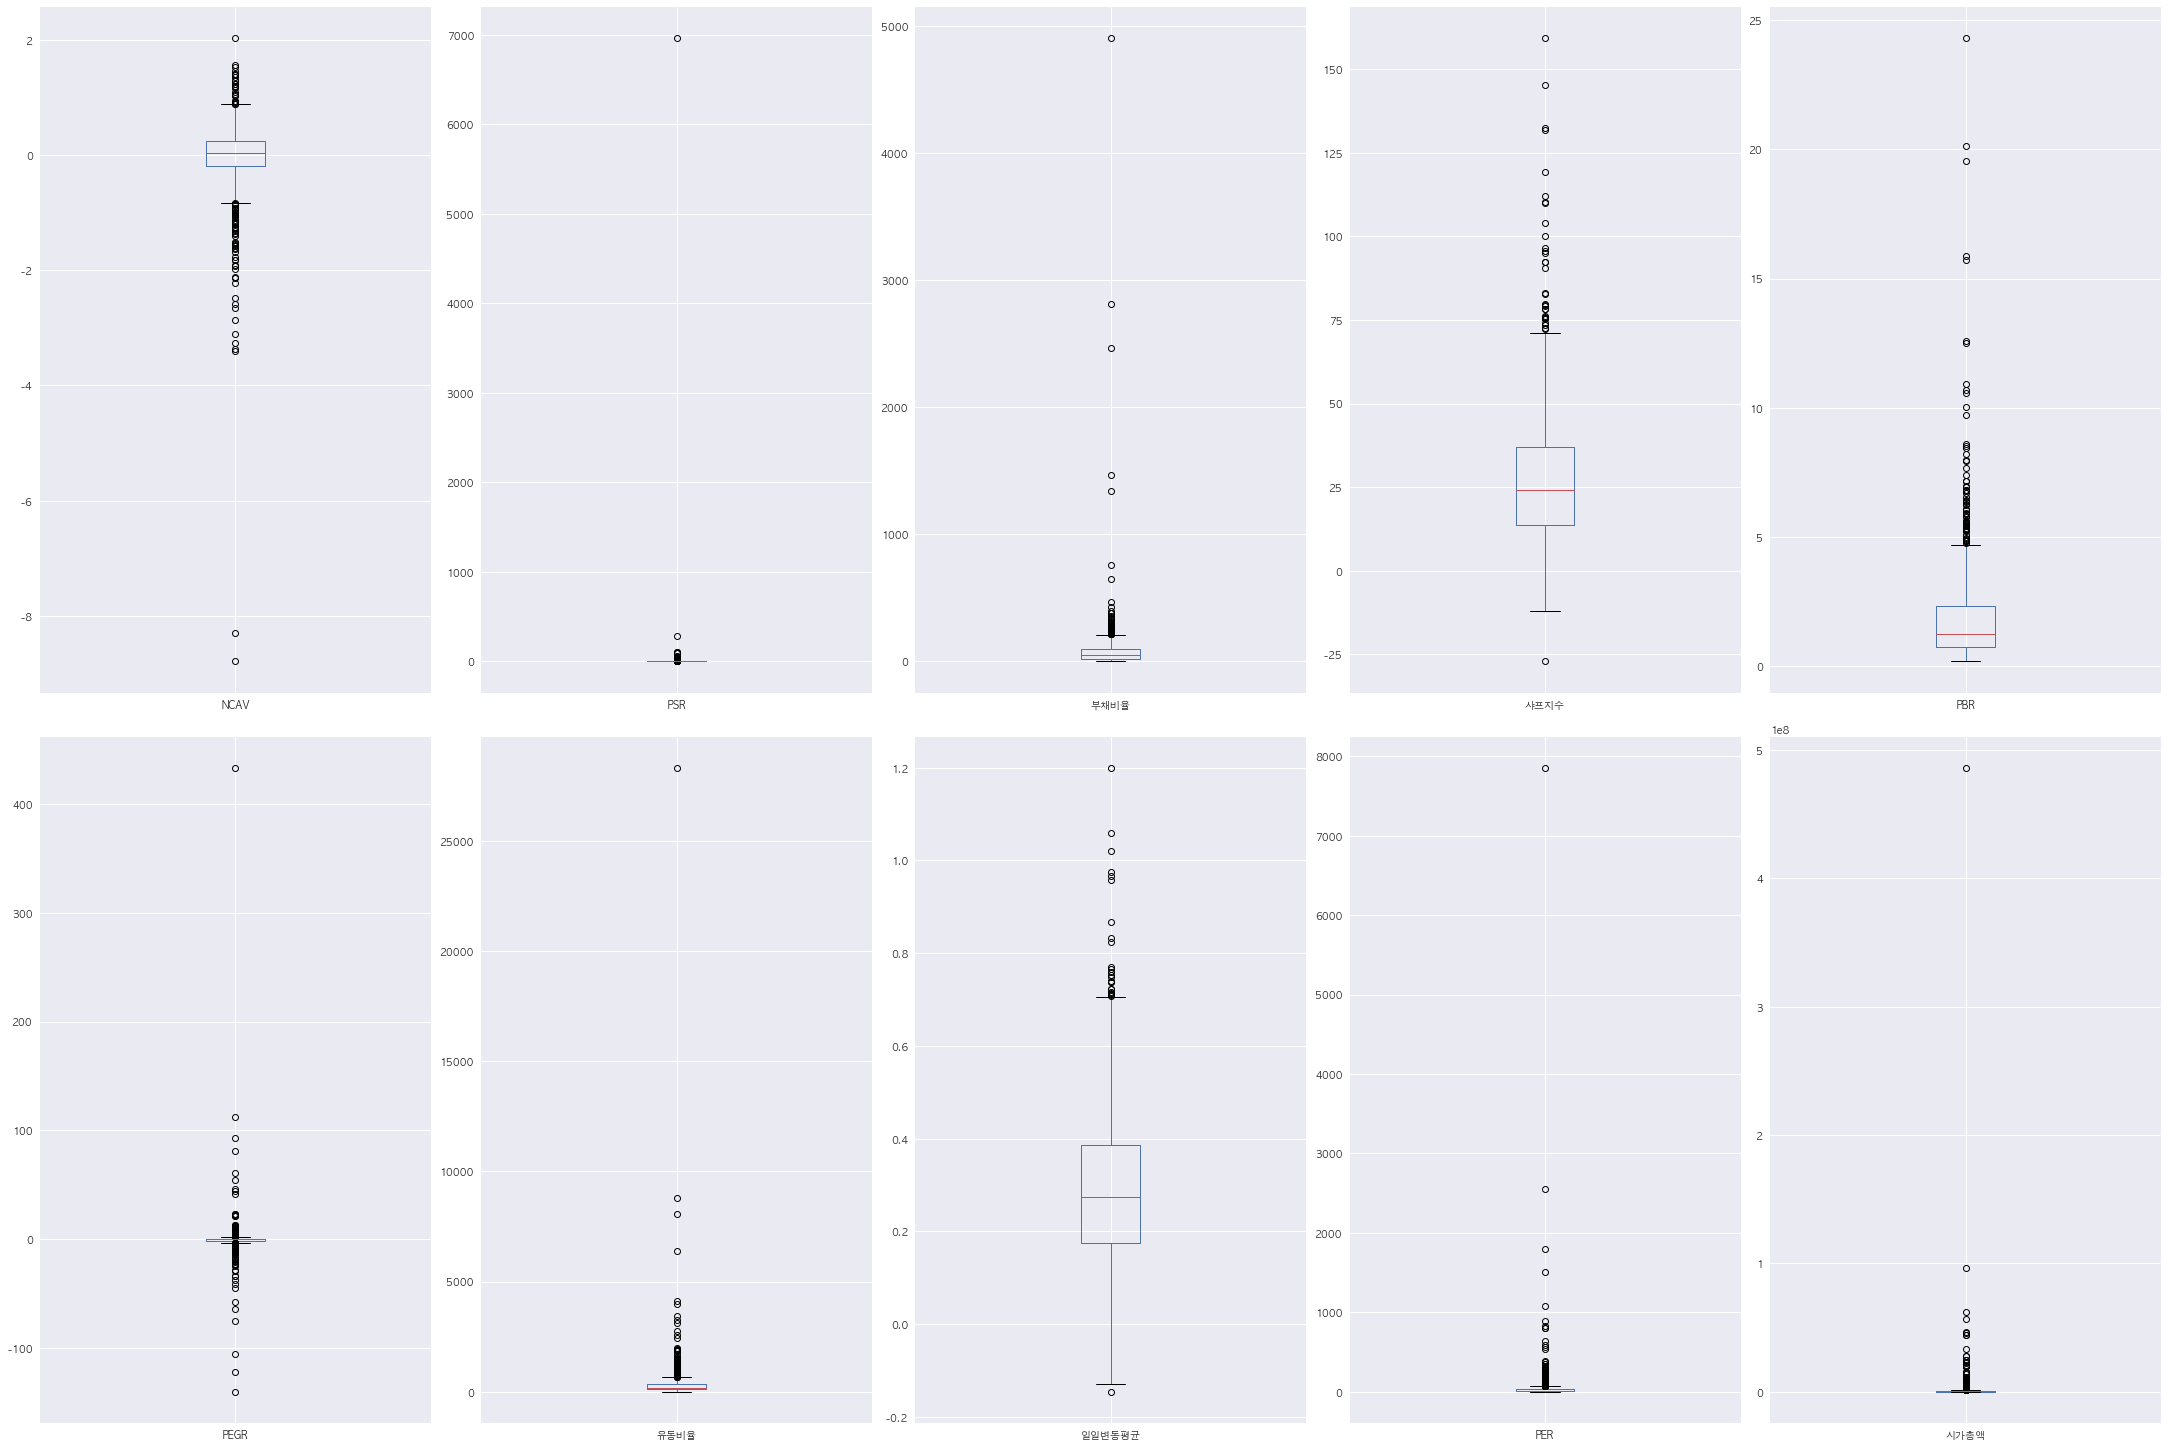

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
import matplotlib

%matplotlib inline
plt.style.use('seaborn')
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "AppleGothic"

ncols = 5
nrows = 2

fig, axs = plt.subplots(nrows, ncols, constrained_layout=True)

fig.set_size_inches((30, 20))

Numericals = list(df_final.select_dtypes(exclude="object").columns)
for col, ax in zip(Numericals, axs.T.ravel()):
    df_final[[col]].boxplot(ax=ax)
    
plt.show()

/Users/kyle/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 45.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot: xlabel='NCAV'>

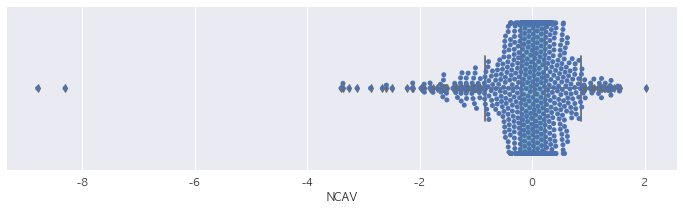

In [61]:
# 이상치 확인
import seaborn as sns
# ['NCAV', 'PEGR', 'PSR', '유동비율', '부채비율', '일일변동평균', '샤프지수', 'PER', 'PBR', '시가총액']
target = "NCAV"

plt.figure(figsize=(12,3))
sns.boxplot(x=target, data=df_final, palette="Set3")
sns.swarmplot(data=df_final, x="NCAV")

## 5-3 이상치 제거
> ## 상하위 몇퍼센트 자를지 boxplot보고 결정 & boxplot작게 찍히는 컬럼은 %를 더 높힐지 상의!

In [62]:
from scipy.stats.mstats import winsorize
print(max(winsorize(df_final['NCAV'], limits=[0.005, 0.005])))
print(min(winsorize(df_final['NCAV'], limits=[0.005, 0.005])))

1.40239963607415
-3.257192835780697


In [66]:
# 전체 종목 윈저라이징 ['NCAV', 'PEGR', 'PSR', '유동비율', '부채비율', '일일변동평균', '샤프지수', 'PER', 'PBR', '시가총액']
from scipy.stats.mstats import winsorize

# 상하위 0.5% 값 확인
# winsorize(df_final['NCAV'], limits=[0.005, 0.005])
# print(max(winsorize(df_final['NCAV'], limits=[0.005, 0.005])))
# print(min(winsorize(df_final['NCAV'], limits=[0.005, 0.005])))


# 이상치 제거 0.5%(필요에 따라 하위 생략)
df_final = df_final[(df_final["NCAV"]> min(winsorize(df_final['NCAV'], limits=[0.01, 0.01]))) \
                            & (df_final["NCAV"] < max(winsorize(df_final['NCAV'], limits=[0.01, 0.01])))] # NCAV
df_final = df_final[(df_final["PEGR"]> min(winsorize(df_final['PEGR'], limits=[0.01, 0.01]))) \
                            & (df_final["PEGR"] < max(winsorize(df_final['PEGR'], limits=[0.01, 0.01])))] # PEGR
df_final = df_final[df_final["PSR"] < max(winsorize(df_final['PSR'], limits=[0.01, 0.01]))] # PSR
df_final = df_final[df_final["유동비율"] < max(winsorize(df_final['유동비율'], limits=[0.01, 0.01]))] # 유동비율
df_final = df_final[df_final["부채비율"] < max(winsorize(df_final['부채비율'], limits=[0.01, 0.01]))] # 부채비율
df_final = df_final[df_final["일일변동평균"] < max(winsorize(df_final['일일변동평균'], limits=[0.01, 0.01]))] # 일일변동평균
df_final = df_final[df_final["샤프지수"] < max(winsorize(df_final['샤프지수'], limits=[0.01, 0.01]))] # 샤프지수
df_final = df_final[df_final["PER"] < max(winsorize(df_final['PER'], limits=[0.01, 0.01]))] # PER
df_final = df_final[df_final["PBR"] < max(winsorize(df_final['PBR'], limits=[0.01, 0.01]))] # PBR
df_final = df_final[df_final["시가총액"] < max(winsorize(df_final['시가총액'], limits=[0.01, 0.01]))] # 시가총액

df_final # 885 -> 779개로

,종목코드,종목명,NCAV,PEGR,PSR,유동비율,부채비율,일일변동평균,샤프지수,PER,PBR,시가총액
0,000990,DB하이텍,0.028653,4.113681,2.670785,174.09,48.29,0.445142,49.648820,23.36,3.89,2499641.0
1,023150,MH에탄올,-0.301897,-0.000000,1.253321,117.69,69.27,0.081587,1.717932,0.00,1.12,64267.0
2,002360,SH에너지화학,0.361237,-0.000000,1.143522,917.82,29.79,0.166757,10.246872,0.00,1.07,104466.0
3,009160,SIMPAC,0.176695,-0.571031,0.779131,125.85,51.22,0.174309,27.341287,20.64,0.48,211992.0
4,100840,SNT에너지,0.779873,0.073893,0.577712,257.09,40.37,0.131054,21.178235,8.24,0.54,132869.0
...,...,...,...,...,...,...,...,...,...,...,...,...
878,111110,호전실업,0.630197,-0.593299,0.313680,189.04,93.35,-0.016119,-3.956150,29.34,0.71,81200.0
880,000850,화천기공,0.763649,7.384076,0.567872,341.83,24.95,0.077436,17.755082,10.23,0.26,76230.0
881,016580,환인제약,0.537149,3.277122,1.954171,798.20,11.09,0.105514,11.548340,14.69,1.22,334801.0
882,094280,효성ITX,-0.235806,1.557279,0.485197,63.82,227.69,0.222635,21.623614,22.47,4.85,233476.0


/var/folders/x3/lny9bbwx64b561c29r4y4z400000gn/T/ipykernel_44706/2589432718.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


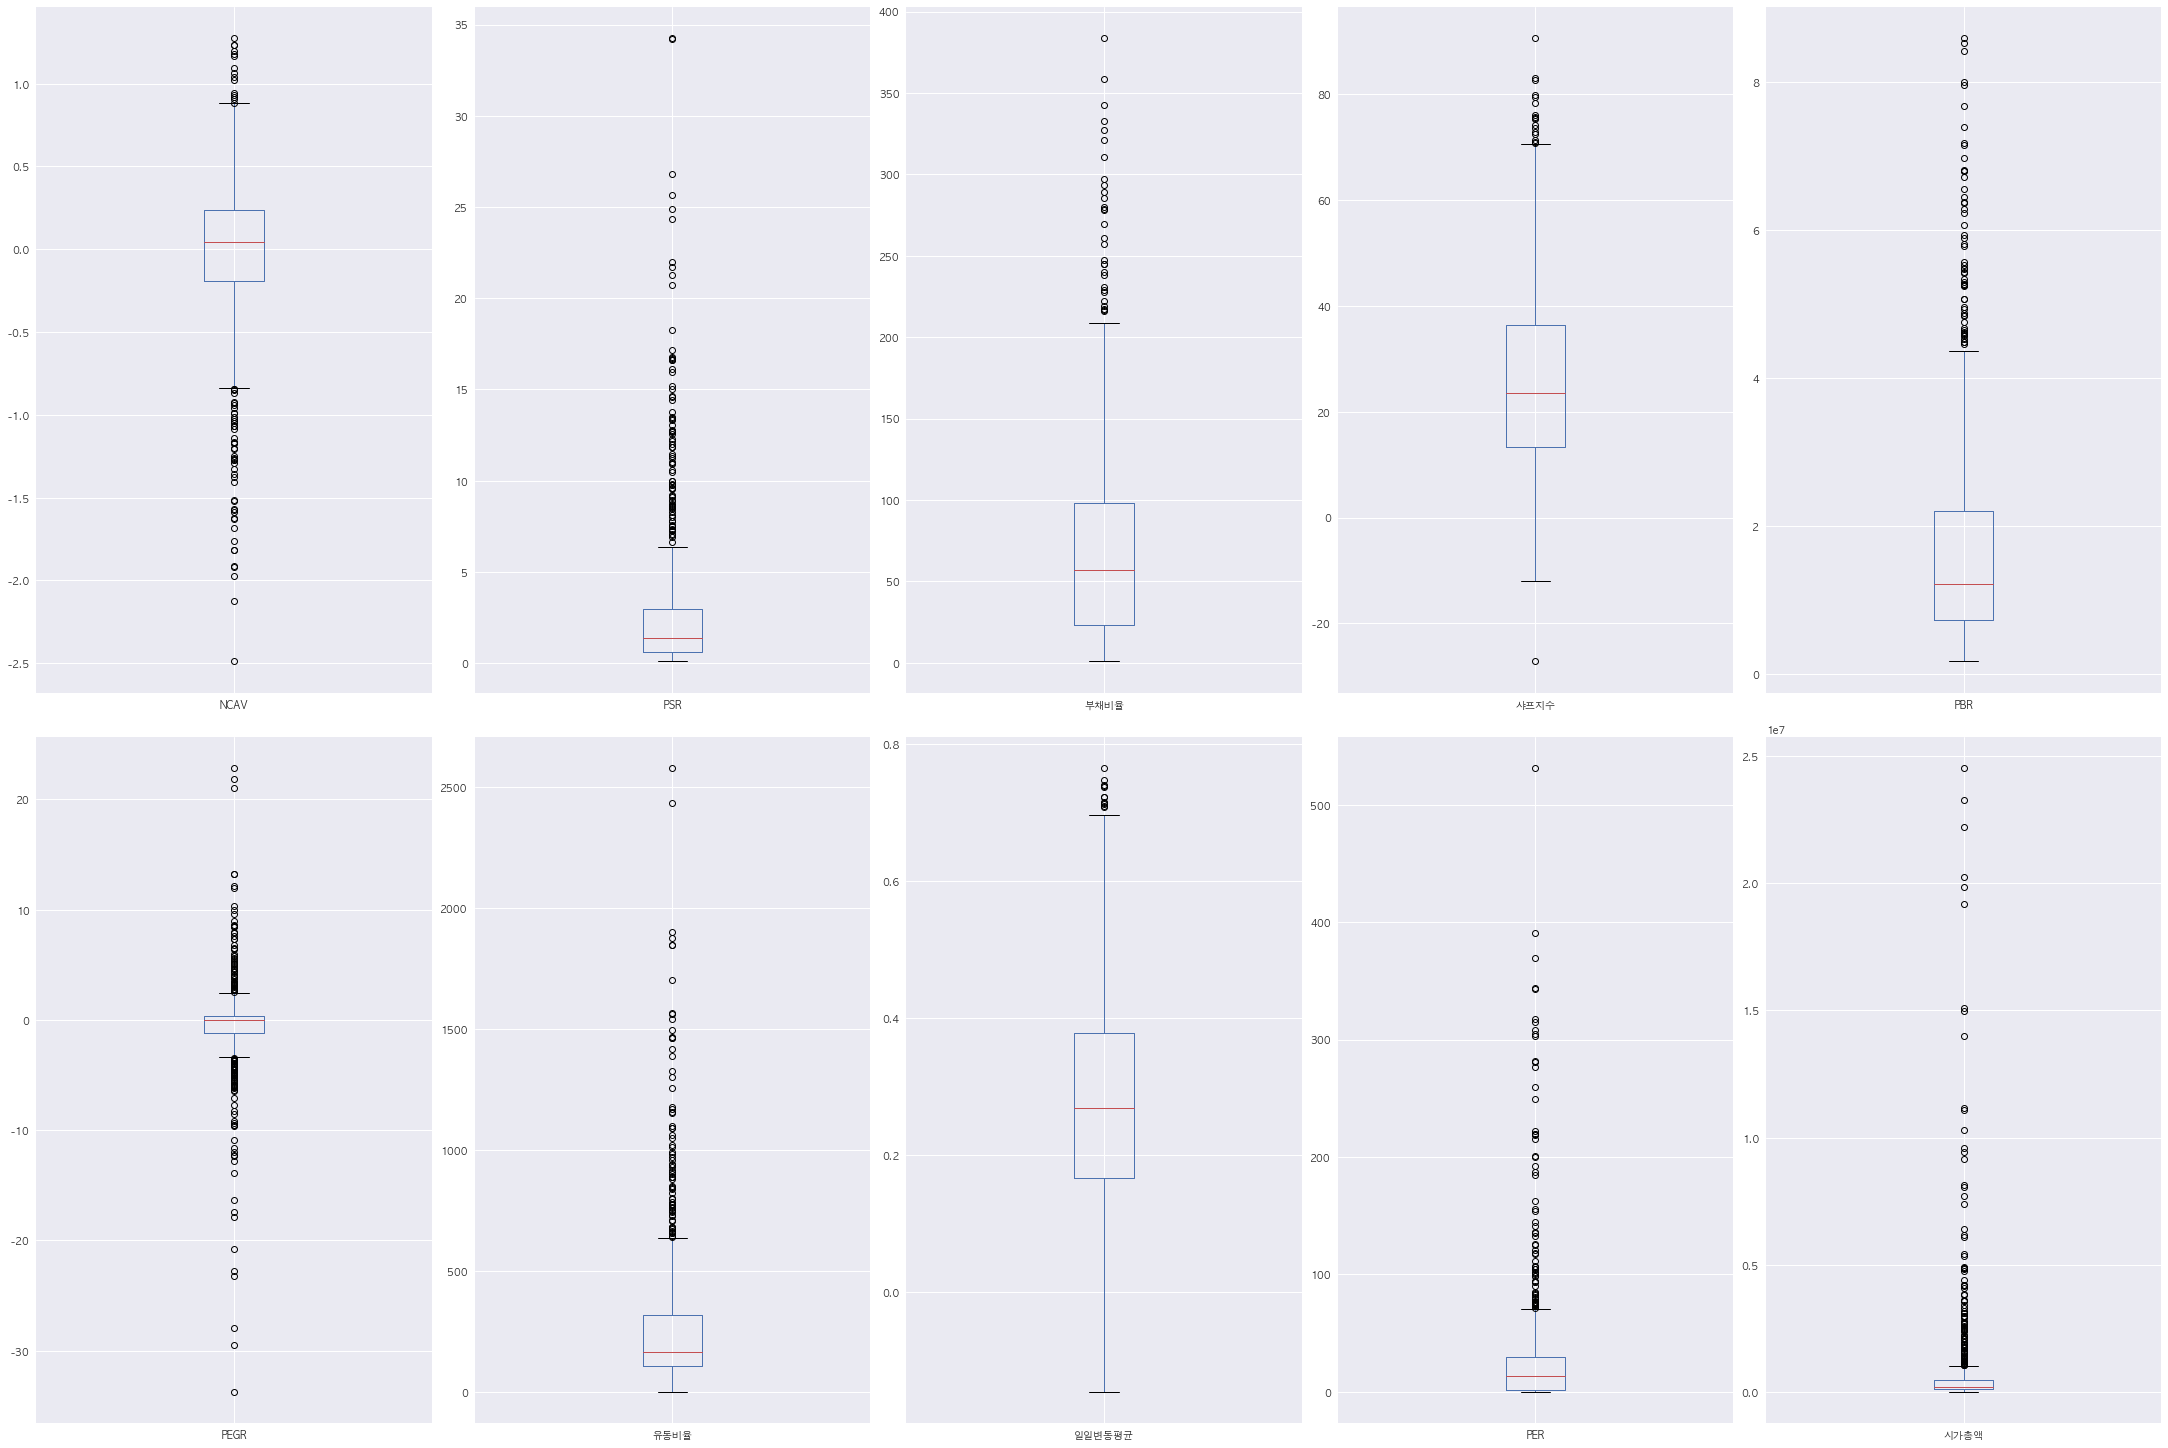

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
import matplotlib

%matplotlib inline
plt.style.use('seaborn')
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "AppleGothic"

ncols = 5
nrows = 2

fig, axs = plt.subplots(nrows, ncols, constrained_layout=True)

fig.set_size_inches((30, 20))

Numericals = list(df_final.select_dtypes(exclude="object").columns)
for col, ax in zip(Numericals, axs.T.ravel()):
    df_final[[col]].boxplot(ax=ax)
    
plt.show()

In [70]:
# 전체 종목 윈저라이징 ['NCAV', 'PEGR', 'PSR', '유동비율', '부채비율', '일일변동평균', '샤프지수', 'PER', 'PBR', '시가총액']
from scipy.stats.mstats import winsorize

# 상하위 0.5% 값 확인
# winsorize(df_final['NCAV'], limits=[0.005, 0.005])
# print(max(winsorize(df_final['NCAV'], limits=[0.005, 0.005])))
# print(min(winsorize(df_final['NCAV'], limits=[0.005, 0.005])))


# 이상치 제거 0.5%(필요에 따라 하위 생략)
df_final = df_final[(df_final["NCAV"]> min(winsorize(df_final['NCAV'], limits=[0.005, 0.005]))) \
                            & (df_final["NCAV"] < max(winsorize(df_final['NCAV'], limits=[0.005, 0.005])))] # NCAV
df_final = df_final[(df_final["PEGR"]> min(winsorize(df_final['PEGR'], limits=[0.005, 0.005]))) \
                            & (df_final["PEGR"] < max(winsorize(df_final['PEGR'], limits=[0.005, 0.005])))] # PEGR
df_final = df_final[df_final["PSR"] < max(winsorize(df_final['PSR'], limits=[0.005, 0.005]))] # PSR
df_final = df_final[df_final["유동비율"] < max(winsorize(df_final['유동비율'], limits=[0.005, 0.005]))] # 유동비율
df_final = df_final[df_final["부채비율"] < max(winsorize(df_final['부채비율'], limits=[0.005, 0.005]))] # 부채비율
df_final = df_final[df_final["일일변동평균"] < max(winsorize(df_final['일일변동평균'], limits=[0.005, 0.005]))] # 일일변동평균
df_final = df_final[df_final["샤프지수"] < max(winsorize(df_final['샤프지수'], limits=[0.005, 0.005]))] # 샤프지수
df_final = df_final[df_final["PER"] < max(winsorize(df_final['PER'], limits=[0.005, 0.005]))] # PER
df_final = df_final[df_final["PBR"] < max(winsorize(df_final['PBR'], limits=[0.005, 0.005]))] # PBR
df_final = df_final[df_final["시가총액"] < max(winsorize(df_final['시가총액'], limits=[0.005, 0.005]))] # 시가총액

df_final # 885 -> 825개로

,종목코드,종목명,NCAV,PEGR,PSR,유동비율,부채비율,일일변동평균,샤프지수,PER,PBR,시가총액
0,000990,DB하이텍,0.028653,4.113681,2.670785,174.09,48.29,0.445142,49.648820,23.36,3.89,2499641.0
1,023150,MH에탄올,-0.301897,-0.000000,1.253321,117.69,69.27,0.081587,1.717932,0.00,1.12,64267.0
2,002360,SH에너지화학,0.361237,-0.000000,1.143522,917.82,29.79,0.166757,10.246872,0.00,1.07,104466.0
3,009160,SIMPAC,0.176695,-0.571031,0.779131,125.85,51.22,0.174309,27.341287,20.64,0.48,211992.0
4,100840,SNT에너지,0.779873,0.073893,0.577712,257.09,40.37,0.131054,21.178235,8.24,0.54,132869.0
...,...,...,...,...,...,...,...,...,...,...,...,...
879,002460,화성산업,1.355497,-0.494554,0.362305,404.04,33.91,0.224000,28.832503,19.24,0.41,151900.0
880,000850,화천기공,0.763649,7.384076,0.567872,341.83,24.95,0.077436,17.755082,10.23,0.26,76230.0
881,016580,환인제약,0.537149,3.277122,1.954171,798.20,11.09,0.105514,11.548340,14.69,1.22,334801.0
882,094280,효성ITX,-0.235806,1.557279,0.485197,63.82,227.69,0.222635,21.623614,22.47,4.85,233476.0


/var/folders/x3/lny9bbwx64b561c29r4y4z400000gn/T/ipykernel_44706/2589432718.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


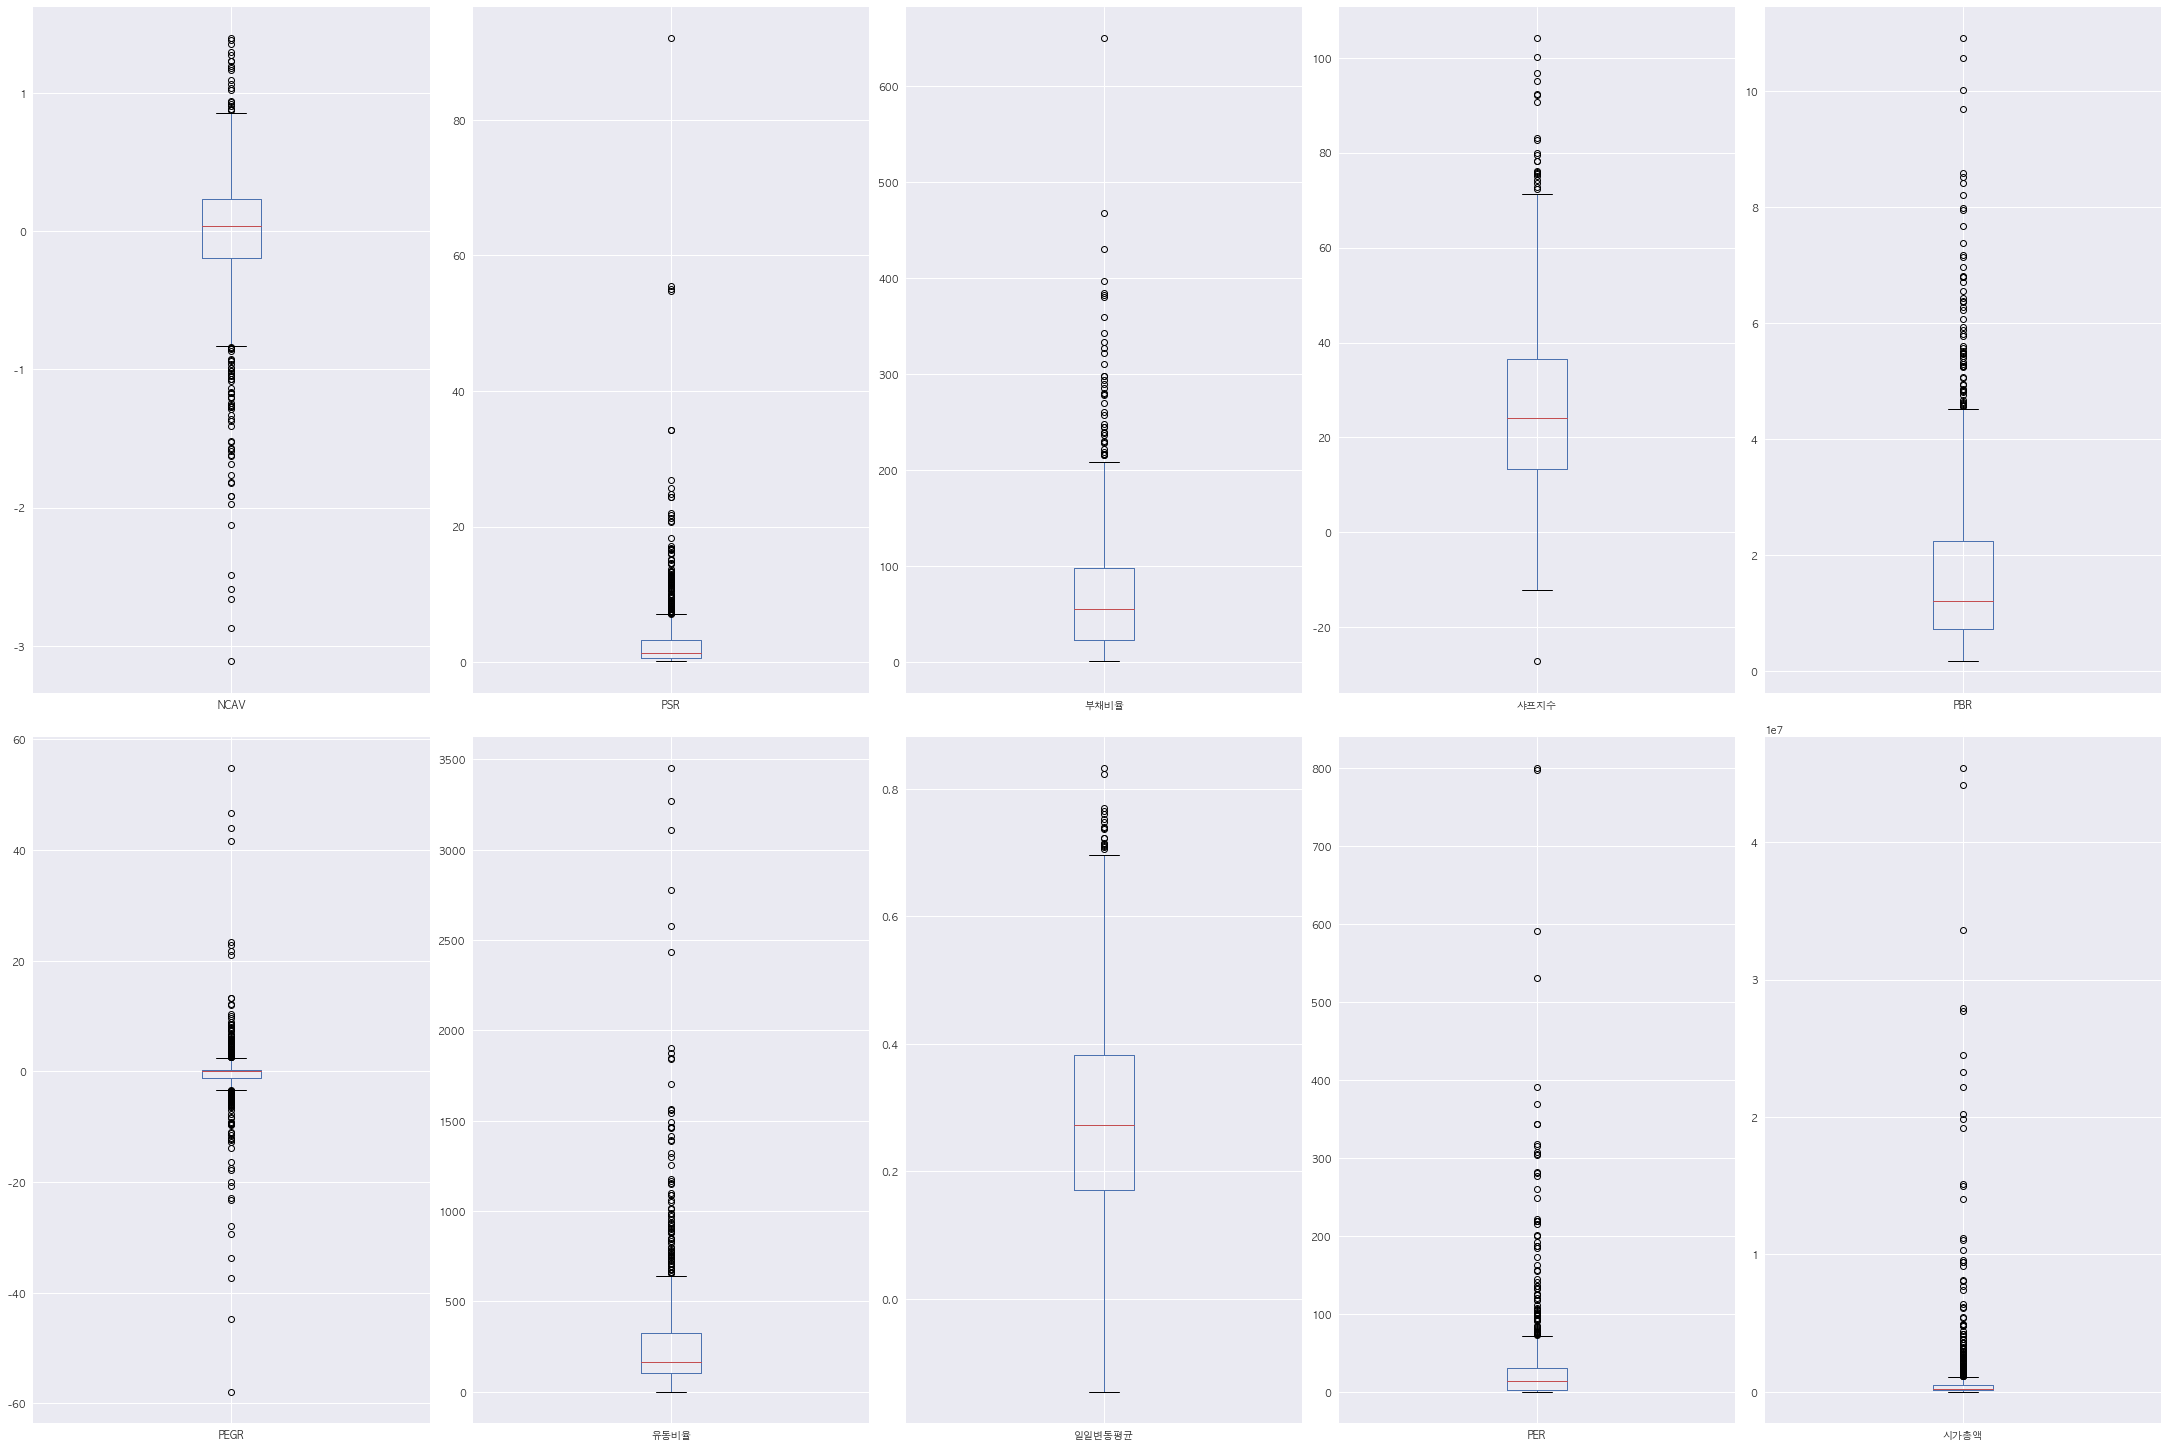

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
import matplotlib

%matplotlib inline
plt.style.use('seaborn')
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "AppleGothic"

ncols = 5
nrows = 2

fig, axs = plt.subplots(nrows, ncols, constrained_layout=True)

fig.set_size_inches((30, 20))

Numericals = list(df_final.select_dtypes(exclude="object").columns)
for col, ax in zip(Numericals, axs.T.ravel()):
    df_final[[col]].boxplot(ax=ax)
    
plt.show()

---

저장

In [ ]:
# df_final.to_csv("./datasets/preprocessed_final.csv")
# df_final.to_excel("./datasets/preprocessed_final.xlsx")
df_final = pd.read_csv("./datasets/preprocessed_final.csv", index_col=0)
df_final["종목코드"] = df_final["종목코드"].astype("str")
df_final["종목코드"] = df_final["종목코드"].map(padding)
df_final # 최종 846개 종목

끝!